# Import dependencies

In [22]:
import json
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn, stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
import numpy as np


In [23]:
# Make sure WordNet is downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [24]:
# ------------------- Load Lightweight SBERT Model -------------------
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')


# Load JSON Dataset

In [25]:
dataset_path = 'train.json'  # Replace with your JSON path

with open(dataset_path, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

In [26]:
dev_path = "dev.json"  # path to your dev JSON

with open(dev_path, 'r', encoding='utf-8') as f:
    dev_data = json.load(f)

# Parse Entries

In [27]:
data_list = []
for key, entry in raw_data.items():
    data_list.append({
        "sample_id": entry.get("sample_id"),
        "homonym": entry.get("homonym"),
        "judged_meaning": entry.get("judged_meaning"),
        "precontext": entry.get("precontext"),
        "sentence": entry.get("sentence"),
        "ending": entry.get("ending"),
        "choices": entry.get("choices"),           # individual human ratings
        "average_rating": entry.get("average"),    # mean rating
        "stdev_rating": entry.get("stdev"),        # standard deviation
        "example_sentence": entry.get("example_sentence")
    })

In [28]:
#  Convert to DataFrame
df = pd.DataFrame(data_list)

#  Combine Full Story Text
df['full_story'] = df['precontext'] + " " + df['sentence']
df['full_story_with_ending'] = df['full_story'] + " " + df['ending']

#  Display Sample
df.head()


,sample_id,homonym,judged_meaning,precontext,sentence,ending,choices,average_rating,stdev_rating,example_sentence,full_story,full_story_with_ending
0,1843,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,She collected a battery reader and looked on e...,"[4, 5, 2, 3, 1]",3.0,1.581139,The circuit has a high potential difference.,The old machine hummed in the corner of the wo...,The old machine hummed in the corner of the wo...
1,1844,potential,the inherent capacity for coming into being,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,She collected a battery reader and looked on e...,"[5, 3, 4, 4, 3]",3.8,0.836660,The project has great potential for success.,The old machine hummed in the corner of the wo...,The old machine hummed in the corner of the wo...
2,1845,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,The machine could make such wonderful clothing...,"[2, 1, 4, 3, 1]",2.2,1.303840,The circuit has a high potential difference.,The old machine hummed in the corner of the wo...,The old machine hummed in the corner of the wo...
3,1846,potential,the inherent capacity for coming into being,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,The machine could make such wonderful clothing...,"[4, 5, 5, 3, 5]",4.4,0.894427,The project has great potential for success.,The old machine hummed in the corner of the wo...,The old machine hummed in the corner of the wo...
4,1847,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,,"[1, 1, 4, 4, 3]",2.6,1.516575,The circuit has a high potential difference.,The old machine hummed in the corner of the wo...,The old machine hummed in the corner of the wo...


# Build_wordnet_knowledge

In [29]:
def build_wordnet_knowledge(homonym):
    """
    Extract WordNet knowledge graph information for all senses of a given homonym.

    Returns a list of dictionaries, one per sense/synset:

    {
        'sense_id': 'track.n.01',
        'definition': "...",
        'examples': [...],
        'lemmas': [...],
        'hypernyms': [...],
        'hyponyms': [...],
        'meronyms': [...],
        'holonyms': [...],
        'synset': synset_object
    }
    """

    synsets = wn.synsets(homonym)

    sense_data = []

    for syn in synsets:
        sense_info = {
            "sense_id": syn.name(),                    # e.g. track.n.01
            "definition": syn.definition(),            # gloss
            "examples": syn.examples(),                # example sentences
            "lemmas": [lem.name() for lem in syn.lemmas()],

            # Hypernyms / Hyponyms
            "hypernyms": [h.name() for h in syn.hypernyms()],
            "hyponyms": [h.name() for h in syn.hyponyms()],

            # Meronyms (part-of) and Holonyms (whole-of)
            "meronyms": [m.name() for m in syn.part_meronyms()],
            "holonyms": [h.name() for h in syn.member_holonyms()],

            "synset": syn                               # store synset object for later similarity use
        }

        sense_data.append(sense_info)

    return sense_data


# Convert NLTK POS tag To WordNet POS tag

In [30]:
def nltk_to_wordnet_pos(pos_tag):
    """Map POS tags to WordNet's format (n, v, a, r)."""
    if pos_tag.startswith('N'):
        return wn.NOUN
    elif pos_tag.startswith('V'):
        return wn.VERB
    elif pos_tag.startswith('J'):
        return wn.ADJ
    elif pos_tag.startswith('R'):
        return wn.ADV
    else:
        return None

In [31]:
# Extract content words from story context

def extract_content_words(text):
    """
    Tokenize, lemmatize, remove stopwords, keep only content words:
    nouns, verbs, adjectives, adverbs.

    Returns a list of clean content words.
    """
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    content_words = []

    for word, tag in pos_tags:
        word_lower = word.lower()

        # Skip stopwords & punctuation
        if word_lower in stop_words or not word_lower.isalpha():
            continue

        wn_pos = nltk_to_wordnet_pos(tag)
        if wn_pos:  # keep only content words
            lemma = lemmatizer.lemmatize(word_lower, wn_pos)
            content_words.append((lemma, wn_pos))

    return content_words


# Build Context Sense List from Story

def build_context_sense_list(precontext, sentence, ending=None):
    """
    Processes the story context and retrieves WordNet synsets for all content words.

    Returns a dictionary:
    {
        "content_words": [(lemma, pos), ...],
        "context_synsets": { lemma: [synset1, synset2, ...], ... }
    }
    """

    # Combine text
    full_text = precontext + " " + sentence
    if ending:
        full_text += " " + ending

    # Step A: extract content words
    content_words = extract_content_words(full_text)

    # Step B: map each lemma to its WordNet synsets
    context_synsets = {}
    for lemma, wn_pos in content_words:
        syns = wn.synsets(lemma, pos=wn_pos)

        if syns:  # only store words with synsets
            context_synsets[lemma] = syns

    return {
        "content_words": content_words,
        "context_synsets": context_synsets
    }




In [32]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    return set(tokens)   # use set to measure overlap

#Gloss Overlap Scoring

In [33]:
def gloss_overlap_score(synset, context_words_set):
    """
    score1 = overlap between:
      (gloss + examples)
      and
      (context content words)
    """
    gloss_text = synset.definition()
    example_text = " ".join(synset.examples())

    combined = gloss_text + " " + example_text
    gloss_tokens = preprocess_text(combined)

    overlap = gloss_tokens.intersection(context_words_set)
    return len(overlap)


# Semantic Neighbor Overlap (hypernyms + hyponyms)

def semantic_neighbor_overlap_score(synset, context_words_set):
    """
    score2 = overlap between:
      (gloss+examples of hypernyms, hyponyms)
      vs
      context content words
    """
    neighbor_text = ""

    # hypernyms + hyponyms
    neighbors = synset.hypernyms() + synset.hyponyms()

    for n in neighbors:
        neighbor_text += n.definition() + " "
        neighbor_text += " ".join(n.examples()) + " "

    neighbor_tokens = preprocess_text(neighbor_text)

    overlap = neighbor_tokens.intersection(context_words_set)
    return len(overlap)



def graph_distance_score(synset, context_synsets):
    """
    score3 = 1 / average shortest path distance
    higher score = closer in WordNet graph
    """
    distances = []

    for ctx_word, syn_list in context_synsets.items():
        for ctx_syn in syn_list:
            d = synset.shortest_path_distance(ctx_syn)
            if d is not None and d > 0:
                distances.append(d)

    if len(distances) == 0:
        return 0.0

    avg_dist = np.mean(distances)
    if avg_dist == 0:
        return 0.0

    return 1.0 / avg_dist



def compute_kg_score_for_sense(
    synset,
    context_words_set,
    context_synsets,
    w1=1.0, w2=1.0, w3=1.0
):
    """
    Computes:
      raw_score = w1*score1 + w2*score2 + w3*score3
    """
    s1 = gloss_overlap_score(synset, context_words_set)
    s2 = semantic_neighbor_overlap_score(synset, context_words_set)
    s3 = graph_distance_score(synset, context_synsets)

    raw = w1*s1 + w2*s2 + w3*s3
    return raw



# 4Y. Compute Plausibility (1–5) for All Senses of a Homonym

def compute_plausibility_scores(
    sense_list,    # list of synsets
    context_words, # list of (lemma, pos)
    context_synsets, # dict: lemma -> synsets
    w1=1.0, w2=1.0, w3=1.0
):
    """
    Returns:
    {
        synset_name: {
            'raw_score': ...,
            'plausibility': ...
        },
        ...
    }
    """
    # Convert context words to a set of tokens
    context_word_tokens = set([w for w, pos in context_words])

    # Compute raw KG scores
    raw_scores = []
    for syn in sense_list:
        score = compute_kg_score_for_sense(
            syn, context_word_tokens, context_synsets, w1, w2, w3
        )
        raw_scores.append(score)

    raw_scores = np.array(raw_scores)

    # Normalize raw scores to [1, 5]
    if raw_scores.max() == raw_scores.min():
        norm_scores = np.ones_like(raw_scores) * 3.0
    else:
        norm_scores = 1 + 4 * (raw_scores - raw_scores.min()) / (raw_scores.max() - raw_scores.min())

    # Build output
    result = {}
    for syn, raw, pl in zip(sense_list, raw_scores, norm_scores):
        result[syn.name()] = {
            "raw_score": float(raw),
            "plausibility": float(pl)
        }

    return result




# Evaluate the Model

In [34]:


def evaluate_predictions(df, predicted_scores):
    """
    df: dataframe containing columns:
        - 'average' : human mean rating
        - 'stdev'   : human std dev
    predicted_scores: list/array of predicted scores
    """

    df = df.copy()
    df["pred"] = predicted_scores

    # ---------- Spearman ----------
    rho, _ = spearmanr(df["pred"], df["average"])

    # ---------- Accuracy-within-Std ----------
    df["correct"] = (
        (df["pred"] >= df["average"] - df["stdev"]) &
        (df["pred"] <= df["average"] + df["stdev"])
    ).astype(int)

    accuracy_within_std = df["correct"].mean()

    # ---------- MAE & MSE ----------
    mae = mean_absolute_error(df["average"], df["pred"])
    mse = mean_squared_error(df["average"], df["pred"])

    return {
        "spearman_corr": rho,
        "accuracy_within_std": accuracy_within_std,
        "mae": mae,
        "mse": mse,
        "detailed": df
    }


# Model Prediction

In [35]:



preds = []   # store predicted plausibility for each sample

for idx, row in df.iterrows():

    hom = row["homonym"]
    pre = row["precontext"]
    sent = row["sentence"]
    end = row["ending"]
    judged = row["judged_meaning"]   # gold meaning string

    # ---- A. Build context knowledge ----
    ctx = build_context_sense_list(pre, sent, end)
    context_words = ctx["content_words"]
    context_synsets = ctx["context_synsets"]

    # ---- B. Get all WordNet senses of the homonym ----
    senses = wn.synsets(hom)

    if len(senses) == 0:
        # fallback: neutral plausibility
        preds.append(3)
        continue

    # ---- C. Compute plausibility scores for all senses ----
    score_dict = compute_plausibility_scores(
        senses,
        context_words,
        context_synsets,
        w1=1.0, w2=1.0, w3=1.0
    )

    # ---- D. Pick the predicted score for the GOLD meaning ----
    # The JSON provides meaning text, not synset names → simple fuzzy match
    matched_score = None
    judged_lower = judged.lower()

    for syn_name, d in score_dict.items():
        syn = wn.synset(syn_name)
        gloss = syn.definition().lower()

        if judged_lower[:10] in gloss[:10] or judged_lower.split(" ")[0] in gloss:
            matched_score = d["plausibility"]
            break

    # ---- E. If no match found, use max KG score ----
    if matched_score is None:
        matched_score = max([v["plausibility"] for v in score_dict.values()])

    # ---- F. Round & clamp to [1,5] ----
    matched_score = round(matched_score)
    matched_score = min(max(matched_score, 1), 5)

    preds.append(matched_score)


# Result Calculation

In [36]:
def plot_prediction_errors(df, save_path=None, metrics=None):
    """
    df must contain columns: ['average', 'pred']

    Plots:
    - Predicted vs Gold (only error points)
    - Absolute Error histogram
    """

    # Identify errors only
    errors_df = df[df["correct"] == 0]

    if len(errors_df) == 0:
        print("No errors to plot!")
        return

    golds = errors_df["average"].tolist()
    preds = errors_df["pred"].tolist()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

    # ---------------------------
    # 1. Prediction vs Gold
    # ---------------------------
    axes[0].scatter(golds, preds, alpha=0.7, edgecolors='black', s=50)
    axes[0].plot([min(golds), max(golds)], [min(golds), max(golds)], "r--", label="Perfect")
    axes[0].set_title("Prediction vs Gold (Errors Only)")
    axes[0].set_xlabel("Gold Average")
    axes[0].set_ylabel("Predicted Score")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # ---------------------------
    # 2. Absolute Error Histogram
    # ---------------------------
    abs_errors = np.abs(errors_df["pred"] - errors_df["average"])
    axes[1].hist(abs_errors, bins=20, edgecolor='black', alpha=0.7)
    axes[1].axvline(abs_errors.mean(), color='red', linestyle='--',
                    label=f"Mean = {abs_errors.mean():.3f}")
    axes[1].set_title("Absolute Error Distribution")
    axes[1].set_xlabel("Absolute Error")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(alpha=0.3)
    axes[1].legend()

    # Optional metrics block
    if metrics:
        txt = f"""
Spearman: {metrics['spearman_corr']:.4f}
Acc (within SD): {metrics['accuracy_within_std']:.4f}
MAE: {metrics['mae']:.4f}
MSE: {metrics['mse']:.4f}
"""
        plt.figtext(0.5, -0.05, txt, ha="center", fontsize=11, family="monospace")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print("Figure saved to:", save_path)

    plt.show()


Spearman: 0.06221743921549337
Accuracy-within-std: 0.4070175438596491
MAE: 1.5438304093567252
MSE: 3.5949619883040937


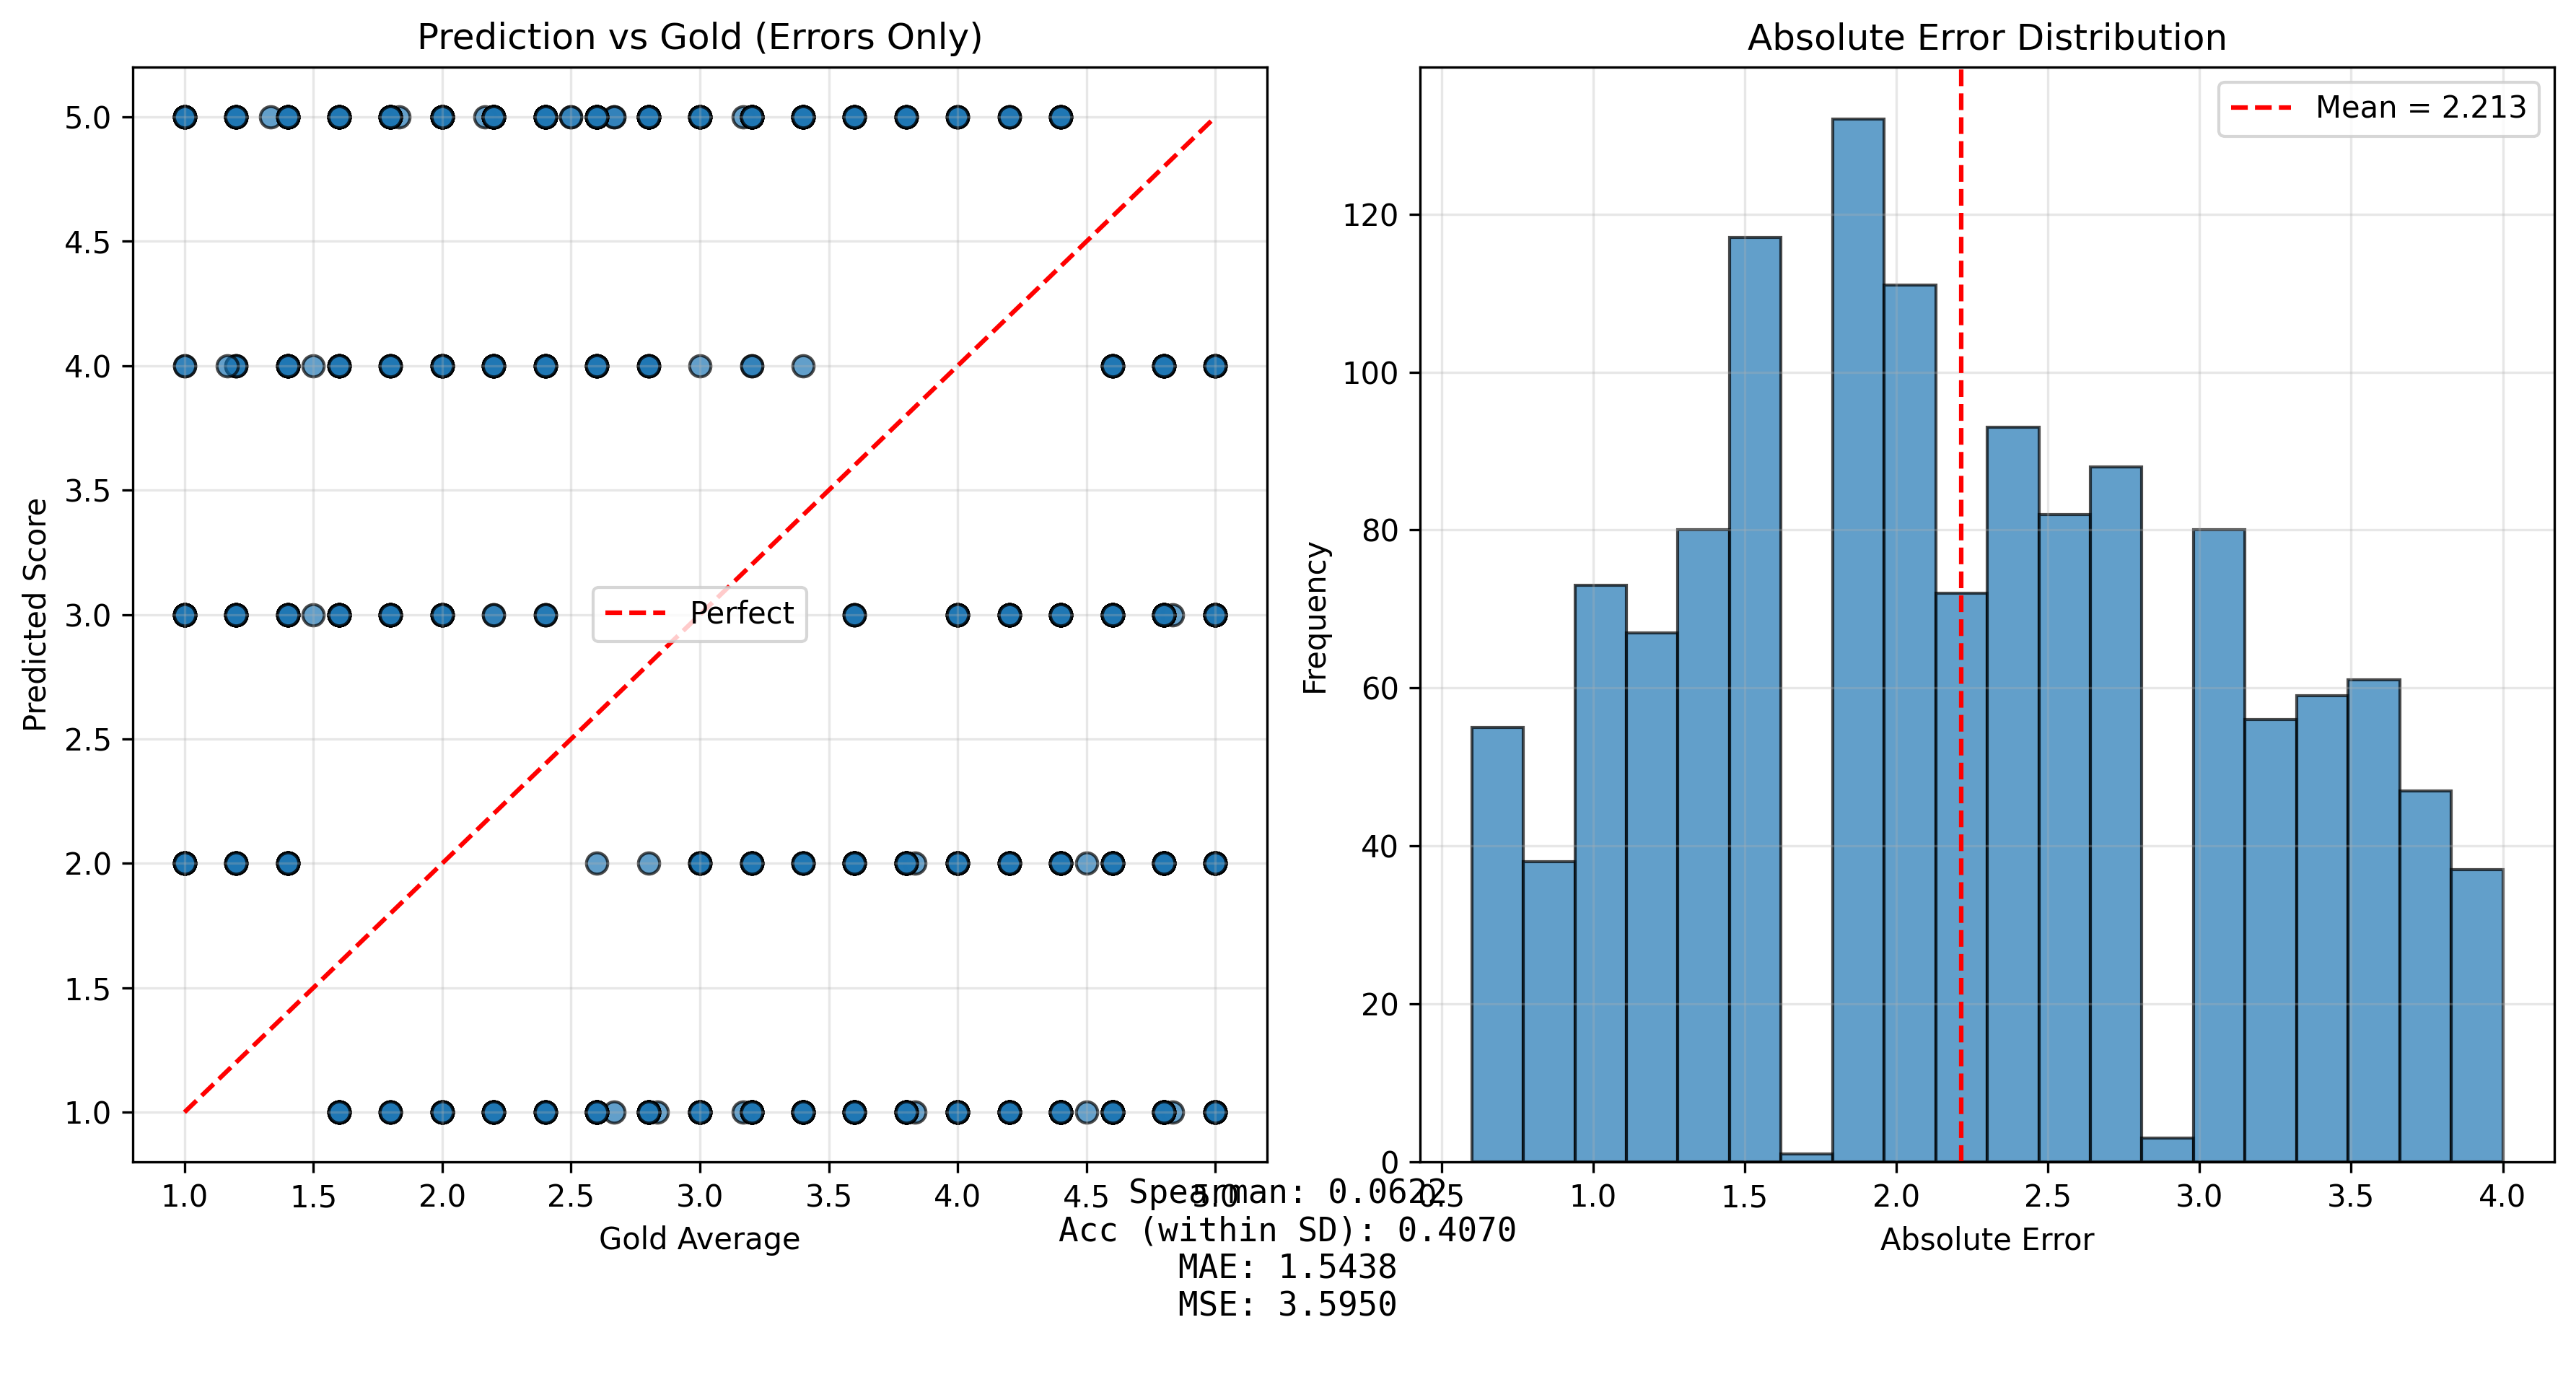

In [37]:
# Evaluate
results = evaluate_predictions(
    df.assign(average=df["average_rating"], stdev=df["stdev_rating"]),
    preds
)

print("Spearman:", results["spearman_corr"])
print("Accuracy-within-std:", results["accuracy_within_std"])
print("MAE:", results["mae"])
print("MSE:", results["mse"])

# Plot Errors
plot_prediction_errors(results["detailed"], metrics=results)


# Hybrid WSD

In [38]:
def encode_context(precontext, sentence, ending=None):
    text = precontext + " " + sentence
    if ending:
        text += " " + ending
    return sbert_model.encode(text, convert_to_tensor=True)

#  Encode Sense Text
def encode_sense(synset):
    sense_text = synset.definition()
    examples_text = " ".join(synset.examples())
    hypernyms_text = " ".join([h.definition() for h in synset.hypernyms()])
    full_text = sense_text + " " + examples_text + " " + hypernyms_text
    return sbert_model.encode(full_text, convert_to_tensor=True)

#  Compute Hybrid Score
def compute_hybrid_score(synset, context_emb, kg_raw_score, alpha=0.6, beta=0.4):
    # Encode sense
    sense_emb = encode_sense(synset)

    # Cosine similarity
    vec_score = util.cos_sim(context_emb, sense_emb).item()  # scalar

    # Combine KG + Embedding
    final_score = alpha * vec_score + beta * kg_raw_score
    return final_score

# Hybrid Predictions

Hybrid Spearman: 0.0924211932389707
Hybrid Accuracy-within-std: 0.43026315789473685
Hybrid MAE: 1.4919883040935673
Hybrid MSE: 3.377213450292398


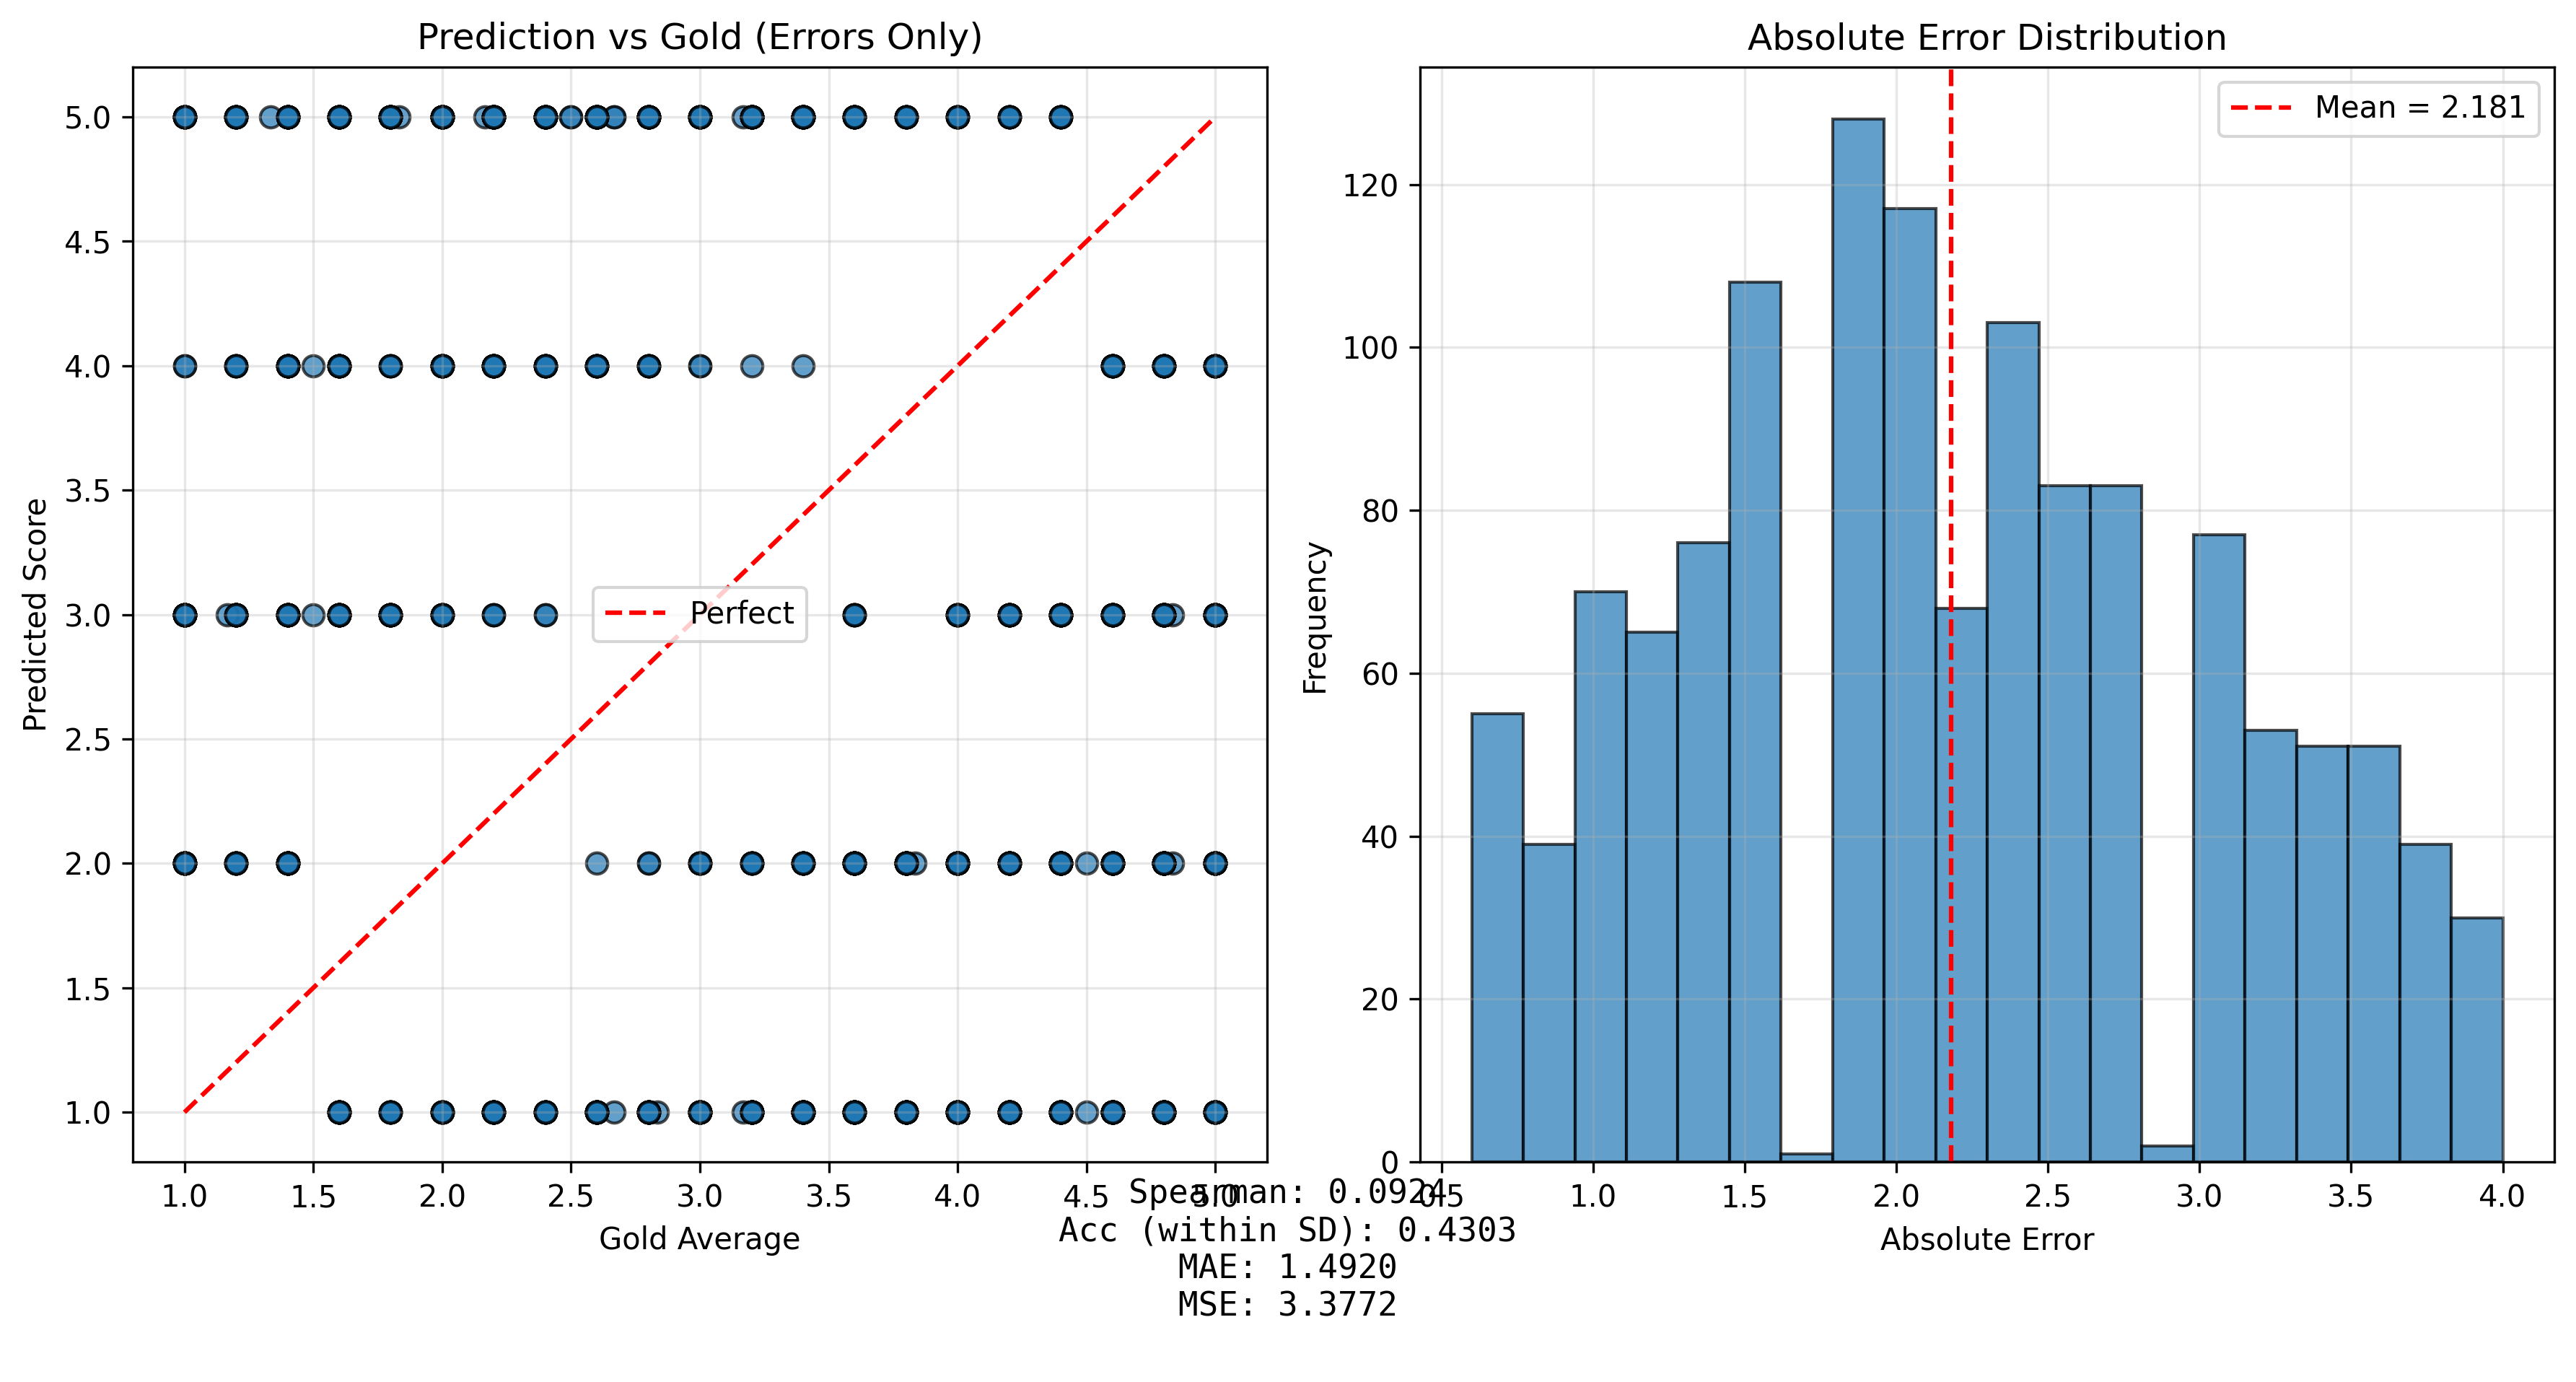

In [39]:
# -------------------------------
# 1. Generate Hybrid Predictions
# -------------------------------
hybrid_preds = []

for idx, row in df.iterrows():
    hom = row["homonym"]
    pre = row["precontext"]
    sent = row["sentence"]
    end = row["ending"]
    judged = row["judged_meaning"]

    # ---- A. Build context knowledge ----
    ctx = build_context_sense_list(pre, sent, end)
    context_words = ctx["content_words"]
    context_synsets = ctx["context_synsets"]

    # ---- B. Get WordNet senses ----
    senses = wn.synsets(hom)
    if len(senses) == 0:
        hybrid_preds.append(3)
        continue

    # ---- C. Compute KG scores ----
    score_dict = compute_plausibility_scores(
        senses, context_words, context_synsets, w1=1.0, w2=1.0, w3=1.0
    )

    # ---- D. Encode context once ----
    context_emb = encode_context(pre, sent, end)

    # ---- E. Compute hybrid scores for all senses ----
    hybrid_scores = {}
    for syn in senses:
        kg_raw = score_dict[syn.name()]["raw_score"]
        hybrid_scores[syn.name()] = compute_hybrid_score(syn, context_emb, kg_raw, alpha=0.6, beta=0.4)

    # ---- F. Pick predicted score for GOLD meaning ----
    matched_score = None
    judged_lower = judged.lower()
    for syn_name, score in hybrid_scores.items():
        syn = wn.synset(syn_name)
        gloss = syn.definition().lower()
        if judged_lower[:10] in gloss[:10] or judged_lower.split(" ")[0] in gloss:
            matched_score = score
            break

    # ---- G. If no match, use max hybrid score ----
    if matched_score is None:
        matched_score = max(hybrid_scores.values())

    # ---- H. Normalize, clamp & round to [1,5] ----
    min_score = min(hybrid_scores.values())
    max_score = max(hybrid_scores.values())
    if max_score == min_score:
        norm_score = 3.0
    else:
        norm_score = 1 + 4 * (matched_score - min_score) / (max_score - min_score)

    norm_score = round(min(max(norm_score, 1), 5))
    hybrid_preds.append(norm_score)

# -------------------------------
# 2. Evaluate Hybrid Predictions
# -------------------------------
results_hybrid = evaluate_predictions(
    df.assign(average=df["average_rating"], stdev=df["stdev_rating"]),
    hybrid_preds
)

print("Hybrid Spearman:", results_hybrid["spearman_corr"])
print("Hybrid Accuracy-within-std:", results_hybrid["accuracy_within_std"])
print("Hybrid MAE:", results_hybrid["mae"])
print("Hybrid MSE:", results_hybrid["mse"])

# -------------------------------
# 3. Plot Hybrid Prediction Errors
# -------------------------------
plot_prediction_errors(results_hybrid["detailed"], metrics=results_hybrid)


In [40]:
# Parse dev JSON like train
dev_list = []
for key, entry in dev_data.items():
    dev_list.append({
        "sample_id": entry.get("sample_id"),
        "homonym": entry.get("homonym"),
        "judged_meaning": entry.get("judged_meaning"),
        "precontext": entry.get("precontext"),
        "sentence": entry.get("sentence"),
        "ending": entry.get("ending"),
        "choices": entry.get("choices"),
        "average_rating": entry.get("average"),
        "stdev_rating": entry.get("stdev"),
        "example_sentence": entry.get("example_sentence")
    })

dev_df = pd.DataFrame(dev_list)
dev_df['full_story'] = dev_df['precontext'] + " " + dev_df['sentence']
dev_df['full_story_with_ending'] = dev_df['full_story'] + " " + dev_df['ending']

dev_df.head()


,sample_id,homonym,judged_meaning,precontext,sentence,ending,choices,average_rating,stdev_rating,example_sentence,full_story,full_story_with_ending
0,2371,track,a pair of parallel rails providing a runway fo...,The detectives arrived at the abandoned train ...,They followed the track.,They began to run along the abandoned railway ...,"[4, 5, 3, 1, 5]",3.6,1.673320,The train glided smoothly along the track.,The detectives arrived at the abandoned train ...,The detectives arrived at the abandoned train ...
1,2372,track,evidence pointing to a possible solution,The detectives arrived at the abandoned train ...,They followed the track.,They began to run along the abandoned railway ...,"[3, 3, 4, 4, 4]",3.6,0.547723,The detective found a crucial track.,The detectives arrived at the abandoned train ...,The detectives arrived at the abandoned train ...
2,2373,track,a pair of parallel rails providing a runway fo...,The detectives arrived at the abandoned train ...,They followed the track.,They found interesting clues that helped them ...,"[5, 5, 2, 3, 4]",3.8,1.303840,The train glided smoothly along the track.,The detectives arrived at the abandoned train ...,The detectives arrived at the abandoned train ...
3,2374,track,evidence pointing to a possible solution,The detectives arrived at the abandoned train ...,They followed the track.,They found interesting clues that helped them ...,"[4, 5, 4, 3, 5]",4.2,0.836660,The detective found a crucial track.,The detectives arrived at the abandoned train ...,The detectives arrived at the abandoned train ...
4,2375,track,a pair of parallel rails providing a runway fo...,The detectives arrived at the abandoned train ...,They followed the track.,,"[1, 5, 4, 4, 1]",3.0,1.870829,The train glided smoothly along the track.,The detectives arrived at the abandoned train ...,The detectives arrived at the abandoned train ...


In [41]:
hybrid_preds_dev = []

for idx, row in dev_df.iterrows():
    hom = row["homonym"]
    pre = row["precontext"]
    sent = row["sentence"]
    end = row["ending"]
    judged = row["judged_meaning"]

    ctx = build_context_sense_list(pre, sent, end)
    context_words = ctx["content_words"]
    context_synsets = ctx["context_synsets"]

    senses = wn.synsets(hom)
    if len(senses) == 0:
        hybrid_preds_dev.append(3)
        continue

    score_dict = compute_plausibility_scores(senses, context_words, context_synsets)
    context_emb = encode_context(pre, sent, end)

    hybrid_scores = {}
    for syn in senses:
        kg_raw = score_dict[syn.name()]["raw_score"]
        hybrid_scores[syn.name()] = compute_hybrid_score(syn, context_emb, kg_raw)

    matched_score = None
    judged_lower = judged.lower()
    for syn_name, score in hybrid_scores.items():
        syn = wn.synset(syn_name)
        gloss = syn.definition().lower()
        if judged_lower[:10] in gloss[:10] or judged_lower.split(" ")[0] in gloss:
            matched_score = score
            break

    if matched_score is None:
        matched_score = max(hybrid_scores.values())

    min_score = min(hybrid_scores.values())
    max_score = max(hybrid_scores.values())
    if max_score == min_score:
        norm_score = 3.0
    else:
        norm_score = 1 + 4 * (matched_score - min_score) / (max_score - min_score)

    norm_score = round(min(max(norm_score, 1), 5))
    hybrid_preds_dev.append(norm_score)

# Evaluate
results_dev = evaluate_predictions(
    dev_df.assign(average=dev_df["average_rating"], stdev=dev_df["stdev_rating"]),
    hybrid_preds_dev
)

print("Dev Hybrid Spearman:", results_dev["spearman_corr"])
print("Dev Hybrid Accuracy-within-std:", results_dev["accuracy_within_std"])


Dev Hybrid Spearman: -0.043631918464040326
Dev Hybrid Accuracy-within-std: 0.3843537414965986


In [42]:
print("=== Comparison ===")
print(f"Train Hybrid Spearman: {results_hybrid['spearman_corr']:.4f} | Dev Hybrid Spearman: {results_dev['spearman_corr']:.4f}")
print(f"Train Hybrid Accuracy: {results_hybrid['accuracy_within_std']:.4f} | Dev Hybrid Accuracy: {results_dev['accuracy_within_std']:.4f}")


=== Comparison ===
Train Hybrid Spearman: 0.0924 | Dev Hybrid Spearman: -0.0436
Train Hybrid Accuracy: 0.4303 | Dev Hybrid Accuracy: 0.3844
